Import Libraries

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

#Loading dataset

In [ ]:
BATCH_SIZE = 64

In [ ]:
train_dataset = datasets.CIFAR10(root = 'dataset/',train = True, download = True, transform = transforms.ToTensor())
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset,(40000,10000))
train_loader = DataLoader(dataset = train_dataset,batch_size = BATCH_SIZE,shuffle = True,num_workers=2)
val_loader = DataLoader(dataset = val_dataset,batch_size = BATCH_SIZE,shuffle = True)
test_dataset = datasets.CIFAR10(root = 'dataset/',train = False, download = True, transform = transforms.ToTensor())
test_loader = DataLoader(dataset = test_dataset,batch_size = BATCH_SIZE,shuffle = True,num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting dataset/cifar-10-python.tar.gz to dataset/
Files already downloaded and verified


In [ ]:
print(f'{len(train_loader.dataset)}')
print(f'{len(val_loader.dataset)}')
print(f'{len(test_loader.dataset)}')

40000
10000
10000


# Utility Functions

In [ ]:
def validation(model: torch.nn.modules.module,
               val_loader:torch.utils.data.dataloader,
               loss_fn: torch.nn.modules.loss) -> float:
  '''
  compute validation loss with corresponding model and loss function
  return validation loss
  '''

  model.eval()
  total_loss = 0 
  with torch.no_grad():
    for data, targets in tqdm(val_loader, desc= 'Validation'):
      data = data.to(device)
      targets = targets.to(device)

      

      scores = model(data)

      loss = loss_fn(scores,targets)
      total_loss += loss.item()
      
  model.train()
  
  return total_loss / len(val_loader)


In [ ]:
def training(model: torch.nn.modules.module,
             train_dataset: torch.utils.data.dataloader,
             val_dataset: torch.utils.data.dataloader,
             criterion: torch.nn.modules.loss,
             optimizer:torch.optim,
             epochs: int = 5) -> tuple:


  '''
  train model with given train set and optimizer
  return train and validation losses
  '''
  train_losses = []
  val_losses = []

  for epoch in tqdm(range(epochs) ):
    for  data, targets in tqdm(train_dataset,desc = f'Epoch {epoch + 1}'):
      # convert data and target to device
      data = data.to(device)
      targets = targets.to(device)

      # forward pass
      scores = model(data)
      loss = criterion(scores,targets)

      # backward pass
      optimizer.zero_grad()
      loss.backward()
      # update weights
      optimizer.step()

    #validation
    val_loss = validation(model,val_dataset,criterion)
    train_losses.append(loss.item())
    val_losses.append(val_loss)
    print(f'Train Loss: {np.mean(train_losses):.2f}, ',end = '')
    print(f'Validation Loss: {np.mean(val_losses):.2f}')

  return train_losses, val_losses

In [ ]:
def inference(model: torch.nn.modules.module,
              test_dataset: torch.utils.data.dataloader) -> float:

  '''
  inference model on test set
  return test accuracy
  '''

  n_samples = 0
  n_correct = 0
  model.eval()

  with torch.no_grad():
    for data, targets in tqdm(test_dataset):
      data = data.to(device)
      targets = targets.to(device)

      scores = model(data)
      _, preds = scores.max(1)
      n_correct += (preds == targets).sum().item()
      n_samples += targets.size(0)
  model.train()
  return n_correct / n_samples

In [ ]:
def print_acc(acc: float,train: bool=True)-> None:
  '''
  print accuracy in appropriate format
  '''
  if train:
    print(f"Train Accuracy: {acc * 100:.2f}%")
  else:
    print(f"Test Accuracy: {acc * 100:.2f}%")

#Define Model

In [ ]:
class SimpleCNN(nn.Module):
  def __init__(self, in_channels=3, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=8,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.fc1 = nn.Linear(16 * 8 * 8, num_classes)

  def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x) 
        return x

In [ ]:
input_size = (32, 32)
num_classes = len(test_dataset.classes)
learning_rate = 0.001
EPOCHS = 15

In [ ]:
model = SimpleCNN(in_channels = 3, num_classes =10).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = learning_rate)

In [ ]:
train_losses, val_losses = training(model,train_loader,val_loader,criterion ,optimizer,epochs= EPOCHS)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.31, Validation Loss: 1.51


Epoch 2:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.40, Validation Loss: 1.45


Epoch 3:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.29, Validation Loss: 1.42


Epoch 4:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.28, Validation Loss: 1.40


Epoch 5:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.25, Validation Loss: 1.38


Epoch 6:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.25, Validation Loss: 1.35


Epoch 7:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.27, Validation Loss: 1.33


Epoch 8:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.25, Validation Loss: 1.32


Epoch 9:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.24, Validation Loss: 1.30


Epoch 10:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.24, Validation Loss: 1.29


Epoch 11:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.23, Validation Loss: 1.28


Epoch 12:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.20, Validation Loss: 1.27


Epoch 13:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.19, Validation Loss: 1.26


Epoch 14:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.19, Validation Loss: 1.25


Epoch 15:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.17, Validation Loss: 1.24


In [ ]:
train_acc = inference(model, train_loader)
print_acc(train_acc)

  0%|          | 0/625 [00:00<?, ?it/s]

Train Accuracy: 64.54%


In [ ]:
test_acc= inference(model, test_loader)
print_acc(test_acc,train= False)

  0%|          | 0/157 [00:00<?, ?it/s]

Test Accuracy: 61.05%


In [ ]:
class BigCNN(nn.Module):
  def __init__(self, in_channels=3, num_classes=10):
        super(BigCNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=32,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1)
        )
        self.bn_conv1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.bn_conv2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.bn_conv3 = nn.BatchNorm2d(128)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(128, num_classes)
  def forward(self,x):
        x = F.relu(self.bn_conv1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn_conv2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn_conv3(self.conv3(x)))
        x = self.pool(x)
        x = self.global_avg_pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x) 
        return x

In [ ]:
model = BigCNN(in_channels = 3, num_classes =10).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = learning_rate)

In [ ]:
train_losses, val_losses = training(model,train_loader,val_loader,criterion ,optimizer,epochs= EPOCHS)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.18, Validation Loss: 1.52


Epoch 2:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.02, Validation Loss: 1.39


Epoch 3:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.95, Validation Loss: 1.37


Epoch 4:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.86, Validation Loss: 1.28


Epoch 5:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.85, Validation Loss: 1.23


Epoch 6:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.85, Validation Loss: 1.20


Epoch 7:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.84, Validation Loss: 1.16


Epoch 8:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.82, Validation Loss: 1.12


Epoch 9:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.79, Validation Loss: 1.10


Epoch 10:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.78, Validation Loss: 1.08


Epoch 11:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.76, Validation Loss: 1.06


Epoch 12:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.74, Validation Loss: 1.04


Epoch 13:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.73, Validation Loss: 1.03


Epoch 14:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.71, Validation Loss: 1.01


Epoch 15:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.70, Validation Loss: 0.99


In [ ]:
train_acc = inference(model, train_loader)
print_acc(train_acc)

  0%|          | 0/625 [00:00<?, ?it/s]

Train Accuracy: 81.39%


In [ ]:
test_acc= inference(model, test_loader)
print_acc(test_acc,train= False)

  0%|          | 0/157 [00:00<?, ?it/s]

Test Accuracy: 72.95%


In [ ]:
class CIFAR10CNN(nn.Module):
  def __init__(self, in_channels=3, num_classes=10):
        super(CIFAR10CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=32,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1)
        )
        self.bn_conv1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=32,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1)
        )
        self.bn_conv2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.bn_conv3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(
            in_channels=64,
            out_channels=64,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.bn_conv4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.bn_conv5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(
            in_channels=128,
            out_channels=128,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.bn_conv6 = nn.BatchNorm2d(128)
        self.conv7 = nn.Conv2d(
            in_channels=128,
            out_channels=256,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.bn_conv7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(
            in_channels=256,
            out_channels=256,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.bn_conv8 = nn.BatchNorm2d(256)
        self.max_pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(256, num_classes)
  def forward(self,x):
        x = self.leaky_relu(self.bn_conv1(self.conv1(x)))
        x = self.leaky_relu(self.bn_conv2(self.conv2(x)))
        x = self.max_pool(x)
        x = self.leaky_relu(self.bn_conv3(self.conv3(x)))
        x = self.leaky_relu(self.bn_conv4(self.conv4(x)))
        x = self.max_pool(x)
        x = self.leaky_relu(self.bn_conv5(self.conv5(x)))
        x = self.leaky_relu(self.bn_conv6(self.conv6(x)))
        x = self.max_pool(x)
        x = self.leaky_relu(self.bn_conv7(self.conv7(x)))
        x = self.leaky_relu(self.bn_conv8(self.conv8(x)))
        x = self.max_pool(x)
        x = self.global_avg_pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc1(x) 
        return x

In [ ]:
model = CIFAR10CNN(in_channels = 3, num_classes =10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = learning_rate)

In [ ]:
train_losses, val_losses = training(model,train_loader,val_loader,criterion ,optimizer,epochs= EPOCHS)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.09, Validation Loss: 1.01


Epoch 2:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.98, Validation Loss: 0.93


Epoch 3:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.91, Validation Loss: 0.86


Epoch 4:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.82, Validation Loss: 0.80


Epoch 5:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.73, Validation Loss: 0.77


Epoch 6:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.71, Validation Loss: 0.74


Epoch 7:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.68, Validation Loss: 0.71


Epoch 8:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.63, Validation Loss: 0.71


Epoch 9:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.58, Validation Loss: 0.70


Epoch 10:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.56, Validation Loss: 0.70


Epoch 11:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.53, Validation Loss: 0.69


Epoch 12:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.51, Validation Loss: 0.68


Epoch 13:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.48, Validation Loss: 0.69


Epoch 14:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.46, Validation Loss: 0.69


Epoch 15:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.44, Validation Loss: 0.69


In [ ]:
train_acc = inference(model, train_loader)
print_acc(train_acc)

  0%|          | 0/625 [00:00<?, ?it/s]

Train Accuracy: 96.62%


In [ ]:
test_acc= inference(model, test_loader)
print_acc(test_acc,train= False)

  0%|          | 0/157 [00:00<?, ?it/s]

Test Accuracy: 81.67%


## Confusion Matrix

In [ ]:
def compute_confusion_matrix(model,test_dataset):
  model.eval()
  predicted = []
  labels = []
  with torch.no_grad():
    for data, targets in(test_dataset):
      data = data.to(device)
      
      scores = model(data)
      _, preds = scores.max(1)
      predicted = np.concatenate((predicted,preds.cpu().numpy()))
      labels = np.concatenate((labels,targets.cpu().numpy()))
      
  model.train()

  confusion_mat = confusion_matrix(labels,predicted,normalize = 'true')
  fig, ax = plt.subplots(figsize=(15,15))
  ConfusionMatrixDisplay(confusion_mat, display_labels=test_dataset.dataset.classes).plot(xticks_rotation= 'vertical', ax = ax,colorbar = False, cmap =plt.cm.Blues)
  plt.savefig('confusion_matrix.jpg')
  

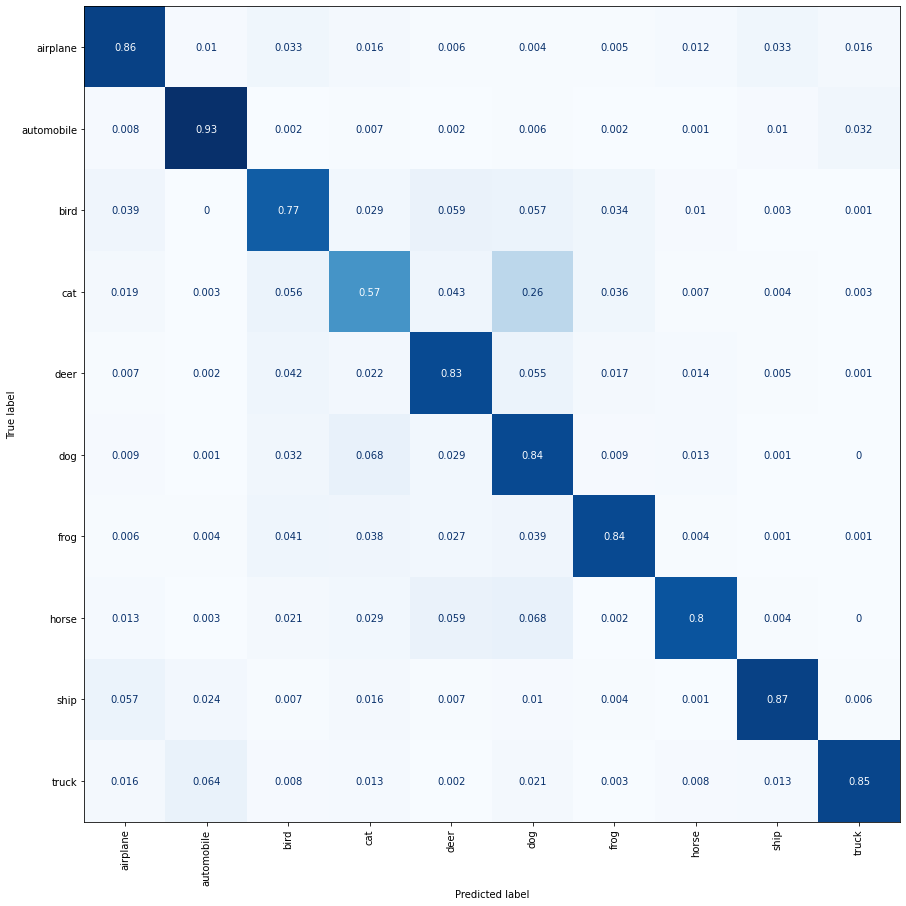

In [ ]:
compute_confusion_matrix(model,test_loader)